In [74]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hmeq-data/hmeq.csv


## Loan Default Prediction using Deep Learning on HMEQ Dataset

This project predicts loan defaults using the **HMEQ dataset**, containing applicants’ financial and personal data. The workflow includes **data preprocessing, handling missing values, encoding categorical features, feature scaling, and addressing class imbalance using SMOTE**. A **deep neural network with Dropout, BatchNormalization, and L2 regularization predicts defaults.** The model achieves ~89% accuracy with balanced precision and recall, helping identify high-risk applicants and supporting informed financial decision-making.

In [75]:
import warnings
warnings.filterwarnings("ignore")

## Load Dataset

In [76]:
dataset = pd.read_csv("/kaggle/input/hmeq-data/hmeq.csv")

In [77]:
dataset.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [78]:
dataset.tail(3)

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
5957,0,89200,54045.0,92924.0,DebtCon,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0,89800,50370.0,91861.0,DebtCon,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882
5959,0,89900,48811.0,88934.0,DebtCon,Other,15.0,0.0,0.0,219.601002,0.0,16.0,34.571519


**Check shape & info**

In [79]:
dataset.shape

(5960, 13)

In [80]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [81]:
dataset.columns

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG',
       'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'],
      dtype='object')

## Data Cleaning

**Check Missing Values**

In [82]:
dataset.isnull().sum()

BAD           0
LOAN          0
MORTDUE     518
VALUE       112
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64

**Handle Missing Values**

In [83]:
for col in dataset.columns:
    if dataset[col].dtype == "object":
        dataset[col].fillna(dataset[col].mode()[0],inplace = True)

    else:
        dataset[col].fillna(dataset[col].mean(),inplace = True)

**Check duplicate rows**

In [84]:
dataset.duplicated().sum()

0

**Explore Target Variable 'BAD'**

In [85]:
bad = dataset["BAD"].value_counts()
print(bad)

BAD
0    4771
1    1189
Name: count, dtype: int64


In [86]:
paid = round(bad[0]/dataset["BAD"].count()*100,2)
default = round(bad[1]/dataset["BAD"].count()*100,2)

print("Percentage of good_loan :", paid )
print()
print("Percentage of bad_loan :", default )

Percentage of good_loan : 80.05

Percentage of bad_loan : 19.95


## Visualization

In [87]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

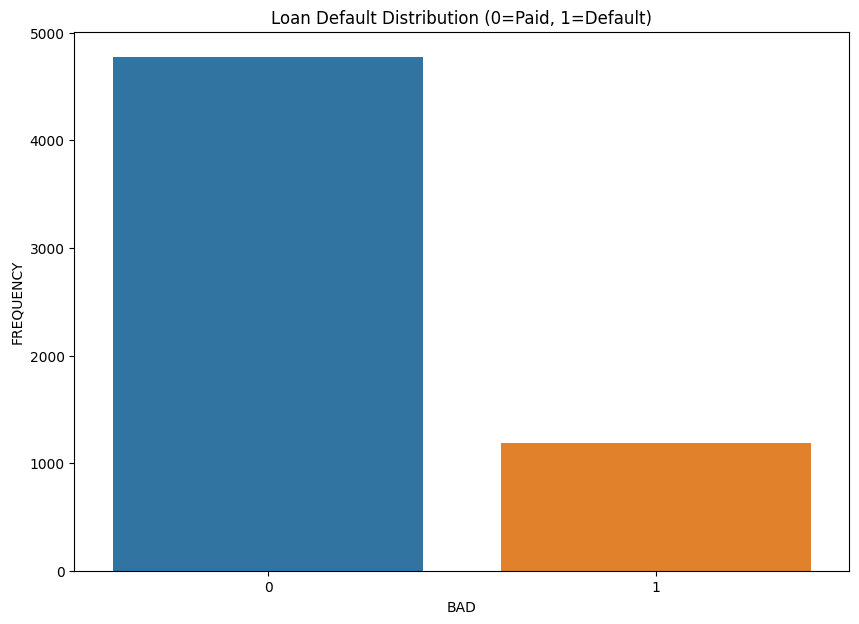

In [88]:
plt.figure(figsize=(10,7))
sns.countplot(x = "BAD", data = dataset)
plt.title("Loan Default Distribution (0=Paid, 1=Default)")
plt.xlabel("BAD")
plt.ylabel("FREQUENCY")
plt.show()

**Feature Distribution and Analysis**

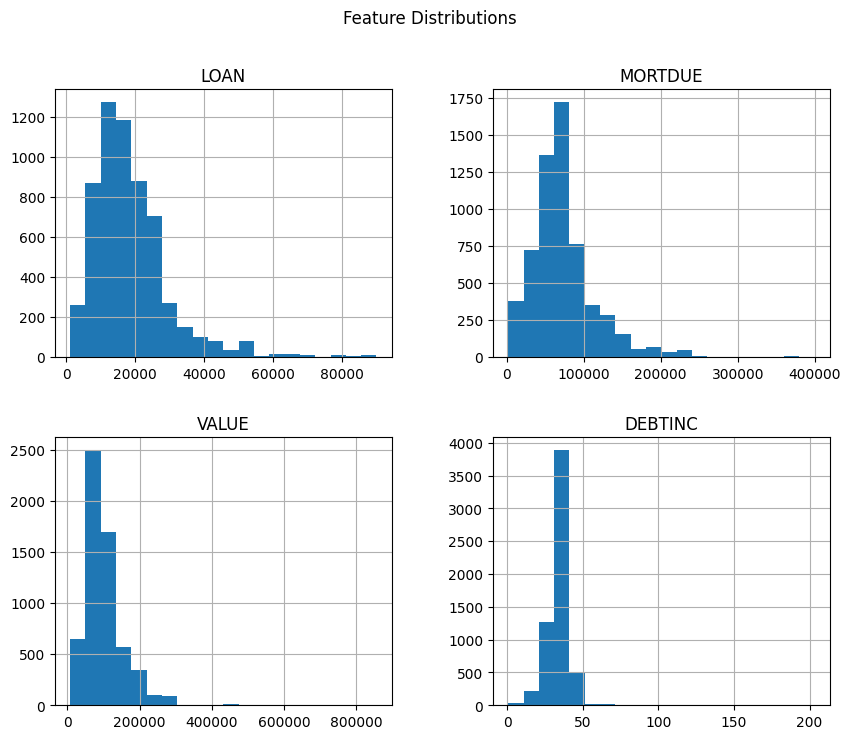

In [89]:
dataset[['LOAN', 'MORTDUE', 'VALUE', 'DEBTINC']].hist(figsize=(10,8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

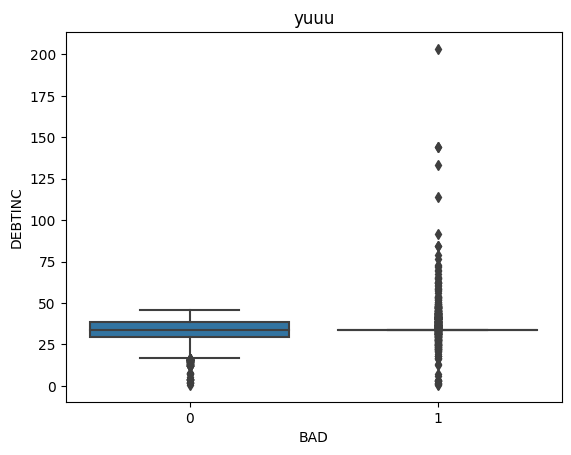

In [90]:
sns.boxplot(x = "BAD", y = "DEBTINC", data = dataset)
plt.title("yuuu")
plt.show()

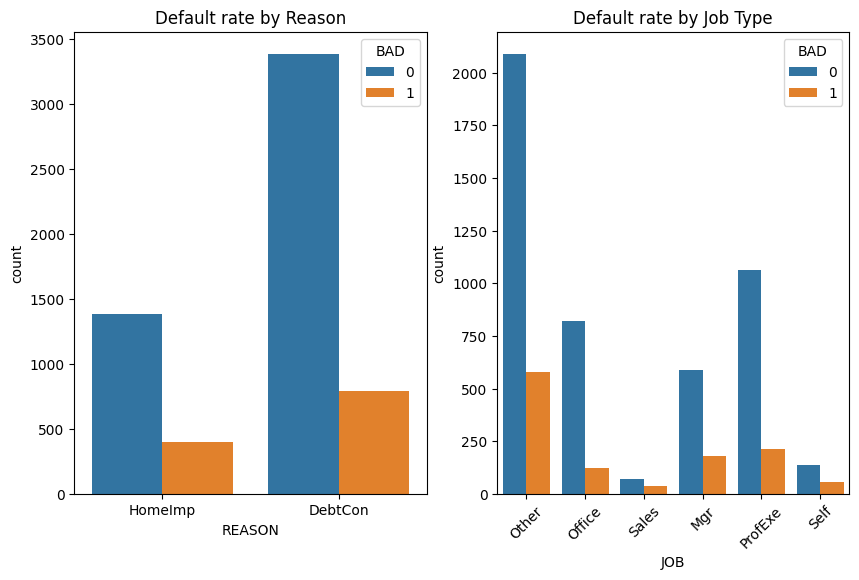

In [91]:
plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
sns.countplot(x='REASON', hue='BAD', data=dataset)
plt.title("Default rate by Reason")

plt.subplot(1,2,2)
sns.countplot(x='JOB', hue='BAD', data=dataset)
plt.title("Default rate by Job Type")
plt.xticks(rotation=45)
plt.show()

## Encode Categorical Columns

In [92]:
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()

dataset["REASON"] = label.fit_transform(dataset["REASON"])
dataset["JOB"] = label.fit_transform(dataset["JOB"])

**Move target to last column**

In [93]:
dataset["BAD"] = dataset.pop("BAD")
dataset.describe()

,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,BAD
count,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000
mean,18607.969799,73760.817200,101776.048741,0.298658,1.931376,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915,0.199497
std,11207.480417,42481.395689,56843.931566,0.457708,1.117147,7.239301,0.794198,1.071002,83.563059,1.653046,9.948280,7.632713,0.399656
min,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499,0.000000
25%,11100.000000,48139.000000,66489.500000,0.000000,1.000000,3.000000,0.000000,0.000000,117.371430,0.000000,15.000000,30.763159,0.000000
50%,16300.000000,69529.000000,90000.000000,0.000000,2.000000,8.000000,0.000000,0.000000,178.076005,1.000000,21.000000,33.779915,0.000000
75%,23300.000000,88200.250000,119004.750000,1.000000,3.000000,12.000000,0.000000,0.449442,227.143058,2.000000,26.000000,37.949892,0.000000
max,89900.000000,399550.000000,855909.000000,1.000000,5.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149,1.000000


**Split dataset into features (x) and target (y)**

In [94]:
x = dataset.iloc[:,:-1]
y = dataset["BAD"]

**Train Test Split**

In [95]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=42,test_size=0.2)

**Feature Scaling**

In [96]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

x_train_scaled = sc.fit_transform(x_train)
x_test_scaled = sc.transform(x_test)

**Handling Class Imbalance with SMOTE**

In [97]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
x_resampled, y_resampled = sm.fit_resample(x_train_scaled,y_train)

In [98]:
from collections import Counter
print("Before resampling :", Counter(y_train))
print("After resampling :", Counter(y_resampled))

Before resampling : Counter({0: 3844, 1: 924})
After resampling : Counter({0: 3844, 1: 3844})


In [99]:
x_resampled.shape

(7688, 12)

## Build Deep Learning Model

In [100]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense,Dropout,BatchNormalization
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.metrics import Precision, Recall
from livelossplot import PlotLossesKerasTF
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [101]:
model = Sequential()

model.add(Input(shape=(12,),name = "Input_Layer"))
model.add(Dense(64,activation="relu",name = "Hidden_Layer_1",kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(48,activation="relu",name = "Hidden_Layer_2",kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(32,activation="relu",name = "Hidden_Layer_3",kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(16,activation="relu",name = "Hidden_Layer_4",kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1,activation="sigmoid",name = "Output_Layer"))

In [102]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer_1 (Dense)          │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_2 (Dense)          │ (None, 48)             │         3,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 48)             │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_3 (Dense)          │ (None, 32)             │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_4 (Dense)          │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,705 (26.19 KB)

 Trainable params: 6,385 (24.94 KB)

 Non-trainable params: 320 (1.25 KB)

**Compile Model**

In [106]:
optimizer = Adam(learning_rate=0.0003)
model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy",Precision(),Recall()])

In [107]:
eraly_stop = EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=True)

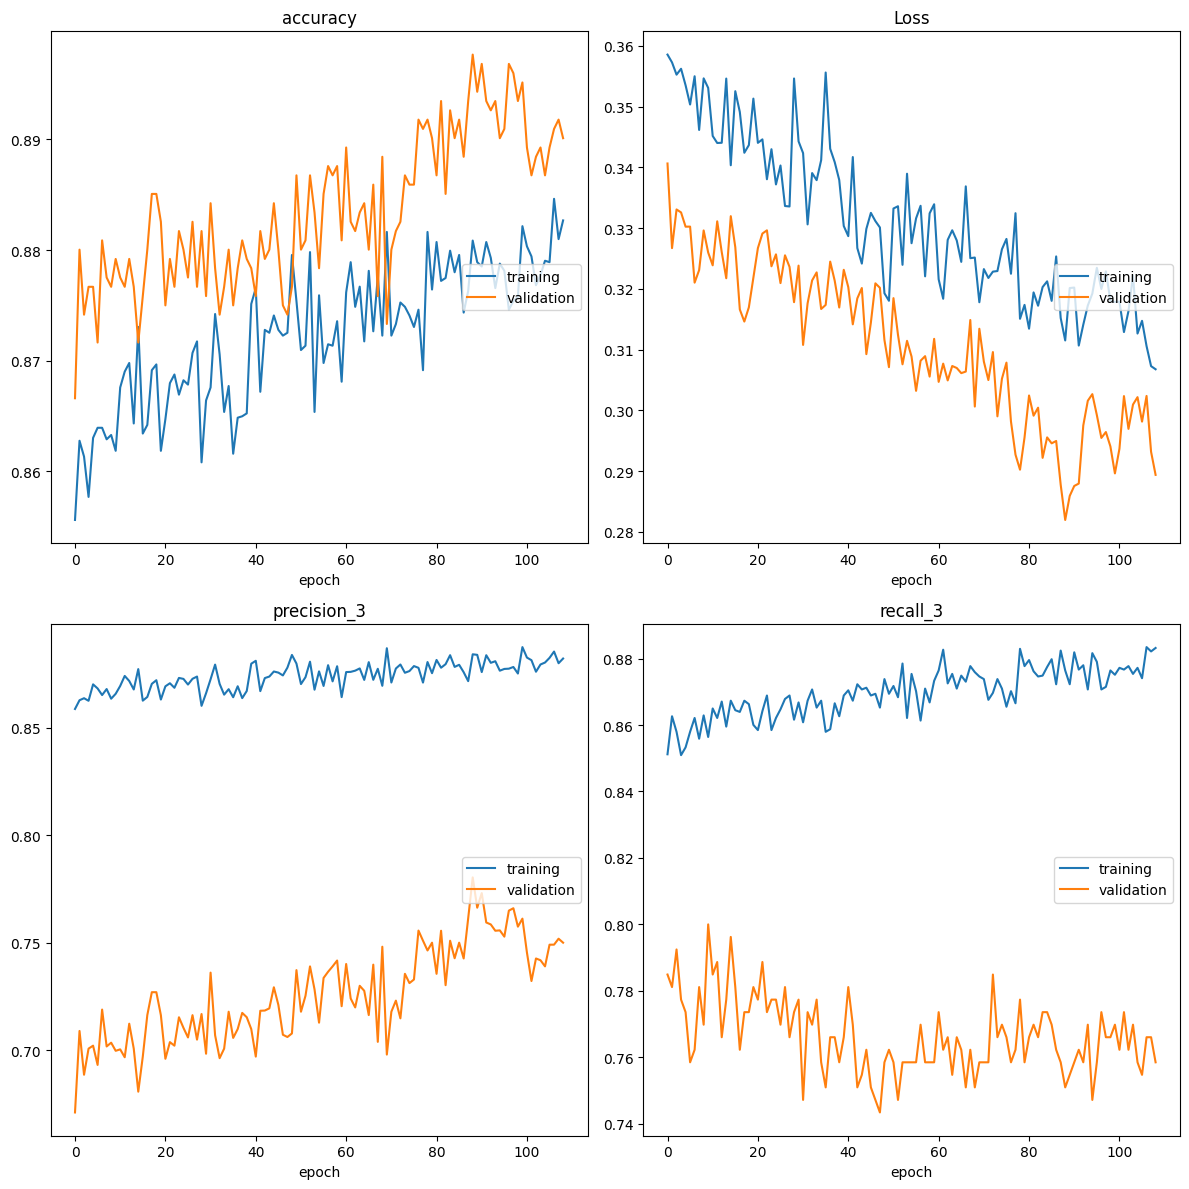

accuracy
	training         	 (min:    0.856, max:    0.885, cur:    0.883)
	validation       	 (min:    0.867, max:    0.898, cur:    0.890)
Loss
	training         	 (min:    0.307, max:    0.359, cur:    0.307)
	validation       	 (min:    0.282, max:    0.341, cur:    0.289)
precision_3
	training         	 (min:    0.859, max:    0.888, cur:    0.882)
	validation       	 (min:    0.671, max:    0.780, cur:    0.750)
recall_3
	training         	 (min:    0.851, max:    0.883, cur:    0.883)
	validation       	 (min:    0.743, max:    0.800, cur:    0.758)
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8893 - loss: 0.2916 - precision_3: 0.8881 - recall_3: 0.8927 - val_accuracy: 0.8901 - val_loss: 0.2894 - val_precision_3: 0.7500 - val_recall_3: 0.7585


In [108]:
history = model.fit(x_resampled,y_resampled,epochs=125,validation_data=(x_test_scaled,y_test),batch_size=55,callbacks=[PlotLossesKerasTF(),eraly_stop ])

**Evaluate Model**

In [109]:
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score

In [110]:
y_pred = (model.predict(x_test_scaled) > 0.5).astype("int32")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred))

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Confusion Matrix:
 [[871  56]
 [ 66 199]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93       927
           1       0.78      0.75      0.77       265

    accuracy                           0.90      1192
   macro avg       0.85      0.85      0.85      1192
weighted avg       0.90      0.90      0.90      1192


ROC-AUC Score: 0.8452667358694104


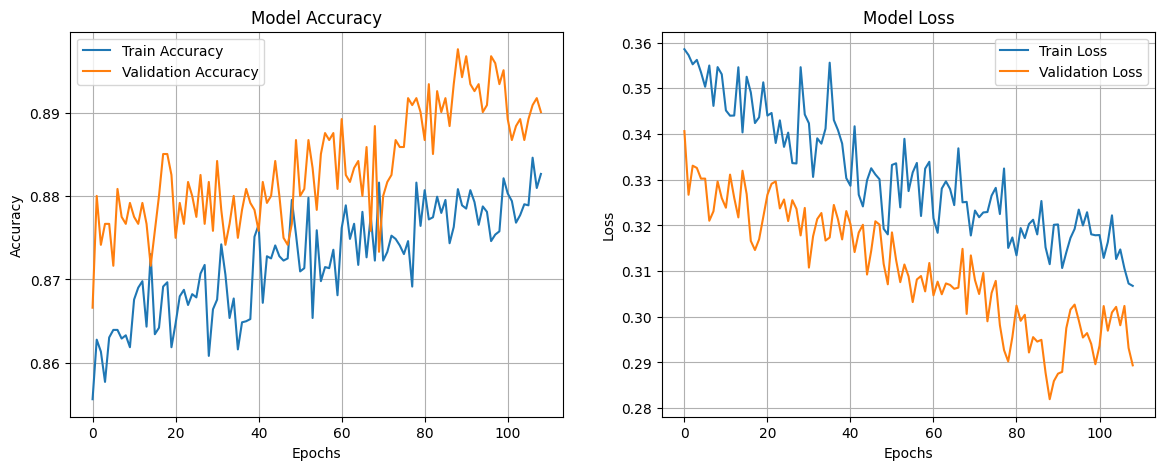

In [111]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()